<h1>Predicting the loss rate of a wireless link</h1>
Every line in the data files loaded here represents the average of 100ms of experimental data. 

The measurements were taken at the ENS Lyon (1H, 2nd, 3rd) and the INSA Lyon (Anechoic chamber) by varying the distance between two IEEE 802.11ac APs acting as source and destination. There is a continuous, saturated UDP stream from the source AP to the destination. 

Because of the nature of the cards and system in use, a third AP placed close to the destination AP is acting as monitor and capturing the exchanged frames. This introduces measurement errors due to the fact that what the monitor captures and what the destination captures will not be the exact same stream of frames. To circumvent this issue, we have considered several different ways of computing the channel quality based on both the data frames and the ACK frames captured by the monitor. These computations are detailed later in the notebook. 

The goal is to build a robust model capable of predicting the link quality that 1) provides an accurate prediction of the link quality and that 2) requires few input features. 

Some of the data will be removed as it seems to produce no measurable lossrate (Anechoic chamber with movement) or because there is too few samples to learn any conclusive rules (Anechoic chamber with obstacle).

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors

%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 13

In [27]:
# define custom colormaps
norm = matplotlib.colors.Normalize(-1,1)
# summer colors (yellow to dar blue with orange and purple)
color1 = '#ffa600'
color2 = '#ff6361'
color3 = '#bc5090'
color4 = '#003f5c'
colors_summer = [[norm(-1.0), color1],
          [norm(-0.6), color2],
          [norm( 0.6), color3],
          [norm( 1.0), color4]]
cmap_summer = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)

# summer colors divergent
color1d = '#003f5c'
color2d = '#4f697e'
color3d = '#8a96a2'
color4d = '#c6c6c6'
color5d = '#e1a9a3'
color6d = '#f38982'
color7d = '#ff6361'
color8dyellow = '#ffc16a' #an extra shade of yellow
color9dgray = '#2a2b2d'
colors_summer = [[norm(-1.0), color1d],
          [norm(-0.6), color2d],
          [norm(-0.3), color3d],
          [norm( 0.0), color4d],
          [norm( 0.3), color5d],
          [norm( 0.6), color6d],
          [norm( 1.0), color7d]]
cmap_summer_divergent = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_summer)
colorlist_summer_divergent = [color1d, color7d, color3d, color5d, color2d, color6d, color4d, color8dyellow, color9dgray]
# salmon-blue colormap
color1sb = '#54bebe'
color2sb = '#8ad6bb'
color3sb = '#c2eabd'
color4sb = '#f9fdca'
color5sb = '#f9d491'
color6sb = '#ffa46e'
color7sb = '#ff6c6c'
colors_salmon_blue = [[norm(-1.0), color1sb],
          [norm(-0.6), color2sb],
          [norm(-0.3), color3sb],
          [norm( 0.0), color4sb],
          [norm( 0.3), color5sb],
          [norm( 0.6), color6sb],
          [norm( 1.0), color7sb]]
cmap_salmon_blue = matplotlib.colors.LinearSegmentedColormap.from_list("", colors_salmon_blue)
colorlist_salmon_blue = [color1sb, color7sb, color3sb, color5sb, color2sb, color6sb, color4sb]

sns.set_palette(colorlist_summer_divergent)

<h4>Read the data and assign the scenario name</h4>

In [28]:
df1 = pd.read_csv('1H/complete_data.csv', sep='\t')
df1['Scenario'] = 'First floor'
df2 = pd.read_csv('2nd/complete_data.csv', sep='\t')
df2['Scenario'] = 'Second floor'
df3 = pd.read_csv('3rd/complete_data.csv', sep='\t')
df3['Scenario'] = 'Third floor'
df4 = pd.read_csv('CA/complete_data.csv', sep='\t')
df4['Scenario'] = 'Anechoic ch.'
df5 = pd.read_csv('CA_move/complete_data.csv', sep='\t')
df5['Scenario'] = 'Anechoic mvmnt'
df6 = pd.read_csv('CA_doubles/complete_data.csv', sep='\t')
df6['Scenario'] = 'Anechoic ch.'
df7 = pd.read_csv('1H_obstacle/complete_data.csv', sep='\t')
df7['Scenario'] = 'Obstacle 1H'
df8 = pd.read_csv('2nd_obstacle/complete_data.csv', sep='\t')
df8['Scenario'] = 'Obstacle 2nd'
df9 = pd.read_csv('3rd_obstacle/complete_data.csv', sep='\t')
df9['Scenario'] = 'Obstacle 3rd'
df4 =pd.concat([df4, df6])
df10 = pd.read_csv('CA_obstacle/complete_data.csv', sep='\t')
df10['Scenario'] = 'Anechoic obstacle'


In [29]:
df1.head()

,time,mcs,nss,bw,rssi,throughput_monitor,datarate,pktlost_ack,nbpkt_monitor,retry,nbpkt_ack,pktlost_seq_initial,pktlost_seq_new,distance,antenna,LoS,Scenario
0,7.974854,5.0,3.0,80.0,-62.274281,3.268404e+07,780.0,10.0,1112.0,54.0,1101.0,9.0,43.0,17,left,1,First floor
1,8.075360,5.0,3.0,80.0,-62.021116,3.947996e+07,780.0,24.0,1326.0,85.0,1312.0,7.0,72.0,17,left,1,First floor
2,8.176077,5.0,3.0,80.0,-62.165485,3.765925e+07,780.0,12.0,1269.0,35.0,1275.0,7.0,41.0,17,left,1,First floor
3,8.276771,5.0,3.0,80.0,-62.189249,4.027103e+07,780.0,36.0,1358.0,74.0,1327.0,11.0,42.0,17,left,1,First floor
4,8.377129,5.0,3.0,80.0,-62.229434,3.958261e+07,780.0,8.0,1325.0,45.0,1332.0,11.0,53.0,17,left,1,First floor


<h4>The features:</h4>
<li>Time: timestamp of the event</li>
<li>MCS: Modulation and Coding Scheme (MCS) index (relates to the data rate, higher MCS index means higher data rate)</li>
<li>NSS: Number of Spatial Streams (number of antennas used for the transmission)</li>
<li>BW: The bandwidth in [20, 40, 80, 160] MHz </li>
<li>RSSI: Measures signal strength in dBm</li>
<li>Throughput monitor: The throughput in bits per second (layer 2, i.e., all layer 3 data is considered as useful)</li>
<li>Datarate: The datarate used for the transmission of the data (impacted by BW, MCS, NSS, GI (guard interval))</li>
<li>Pktlost ack: The number of frames counted as lost from the "missing frames" field in the ACKs</li>
<li>Nbpkt_monitor: Total number of frames captured by the monitor and sent by the source</li>
<li>Retry: Number of frames captured by the moniter having a "retry = 1" flaf</li>
<li>Nbpkt ack: Total number of frames acknowledged in the ACKs captured by the monitor</li>
<li>Pktlost seq initial: The number of lost frames based on sequential numbers. This compu</li>
<li>Pktlost seq new: The number of lost frames based on sequential numbers</li>
<li>Distance: The distance in meters between the source and the destination</li>
<li>Antenna: The orientation of the antenna for all three APs (source, destination, monitor). The orientation can be left, fan, vertical, horizontal.</li>
<li>LoS: Line of Sight. Always 1 except for the scenarios including obstacles</li>
<li>Scenario: The physical location of the experiment and whether an obstacle was present or not</li>

In [30]:
frames = [df1, df2, df3, df7, df8, df9, df4]
for df in frames:
    df['retry_ack'] = df['retry']/df['nbpkt_ack']
    df['retry_monitor'] = df['retry']/df['nbpkt_monitor']
    df['missing_frames_ack'] = df['pktlost_ack']/df['nbpkt_ack']
    df['missing_frames_monitor'] = df['pktlost_ack']/df['nbpkt_monitor']
    df['lossrate_ack'] = df['pktlost_seq_initial']/df['nbpkt_ack']
    df['lossrate_monitor'] = df['pktlost_seq_initial']/df['nbpkt_monitor']
    df.replace([np.inf, -np.inf], np.nan, inplace=True) 
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(subset=['datarate'], inplace=True)
    df.index = range(len(df.index))

data_all = pd.concat(frames)
data_all.index = range(len(data_all.index))
data_copy = data_all.copy()

<ipython-input-31-9bf13969fb3b>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_all.drop('time', axis=1).hist(ax = ax)


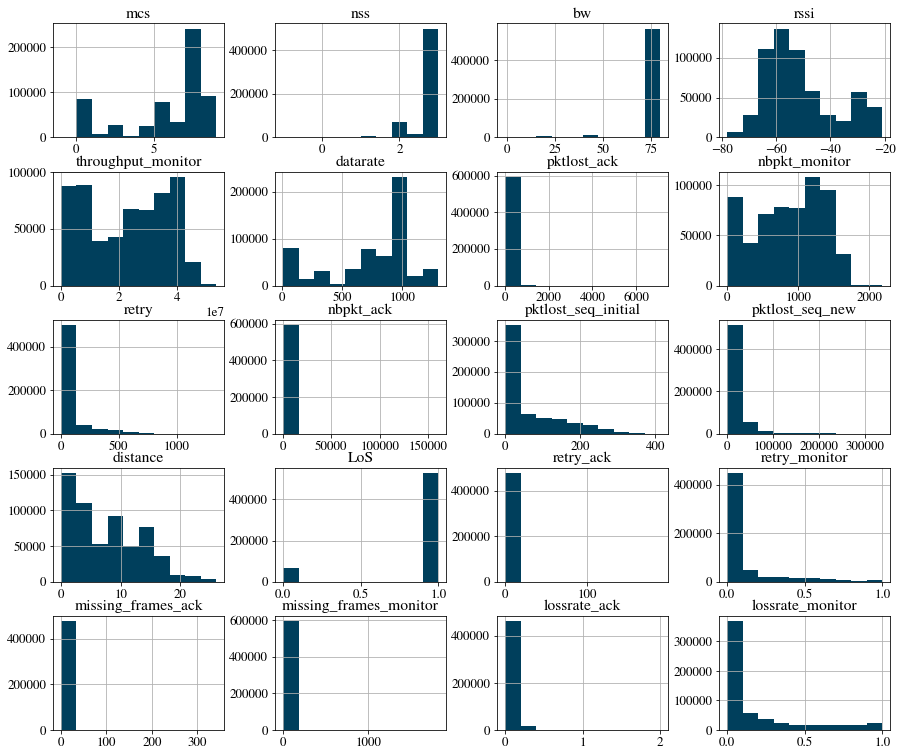

In [31]:
fig = plt.figure(figsize=(15,13))
ax = fig.gca()
data_all.drop('time', axis=1).hist(ax = ax)
plt.show()

I removed the infinities (replaced them with NaNs) that occur because the number of frames as counted by the ACKs is always zero. There are still many values >100\% in all loss rate and retry rate computations:
<li>Retry ack: ratio between the number of retries and the number of acknowledged frames in the ACKs</li>
<li>Missing frames ack: ratio between the numer of lost frames as reported by the ACKs and the number of acknowledged frames in the ACKs</li>
<li>Missing frames monitor: ratio between the number of lost frames as reported by the ACKs and the number of frames counted as well received by the monitor</li>
<li>Lossrate ack: raio between the number of lost frames as counted by the monitor (hopes in the list of sequence numbers) and the number of frames acknowledged by the ACKs</li>

The only values that are reasonably bounded are the retry_monitor, i.e., the number of retries seen by the monitor divided by the number of frames seen by the monitor and the lossrate monitor For the rest of the notebook we'll focus on that metric and compare it with the lossrate from the original computation (that is also properly bounded).

We need to examine ig the "lossrate ack" can potentially be used as well, as it seems like the majority of the data is in the [0,1] interval, so maybe there is only a small section that needs to be removed (if we can understand why).

<h2> Correlations </h2>

We look at [Pearson\'s](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), [Spearman's](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient), and [Kendall's](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient) correlation coefficients for linear and quadratic features. The goal is to find the features, or combinations of features, that correlate the most with the lin quality metric we wish to predict.



In [32]:
print(data_all.corr()['lossrate_monitor'])

mcs                       0.338905
nss                       0.017299
bw                        0.030071
rssi                     -0.154818
throughput_monitor       -0.612848
datarate                  0.309040
pktlost_ack               0.058546
nbpkt_monitor            -0.715909
retry                    -0.312012
nbpkt_ack                 0.252168
pktlost_seq_initial       0.410101
pktlost_seq_new           0.472981
distance                  0.142622
LoS                      -0.113639
retry_ack                -0.053040
retry_monitor            -0.211805
missing_frames_ack       -0.004582
missing_frames_monitor    0.121169
lossrate_ack              0.322058
lossrate_monitor          1.000000
Name: lossrate_monitor, dtype: float64


In [33]:
print(data_all.corr()['retry_monitor'])

mcs                      -0.566222
nss                      -0.326857
bw                       -0.570865
rssi                      0.010302
throughput_monitor       -0.369003
datarate                 -0.621072
pktlost_ack               0.009730
nbpkt_monitor            -0.220397
retry                     0.619459
nbpkt_ack                -0.249725
pktlost_seq_initial      -0.302423
pktlost_seq_new          -0.195619
distance                 -0.032762
LoS                       0.143750
retry_ack                 0.091258
retry_monitor             1.000000
missing_frames_ack        0.039905
missing_frames_monitor    0.072812
lossrate_ack             -0.139999
lossrate_monitor         -0.211805
Name: retry_monitor, dtype: float64


In [34]:
from sklearn.preprocessing import PolynomialFeatures
def features_correlation_simple(X, Y_loss, Y_retry, scenario, degree=2, method = 'spearman'):
    # create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(X)
    # calculate correlation coefficients 
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=X.columns))
    poly_features['lossrate'] = Y_loss
    poly_features['retryrate'] = Y_retry
    poly_features['Scenario'] = scenario
    lossrate_corr = poly_features.corr(method=method)['lossrate']#.sort_values(key=abs)
    retryrate_corr = poly_features.corr()['retryrate']#.sort_values(key=abs)

    sorted_index = lossrate_corr.abs().argsort()
    fig, ax = plt.subplots(figsize = (20,7))    
    x_axis = np.arange(len(lossrate_corr))
    ax.bar(x_axis-0.2, height=lossrate_corr[sorted_index].abs(), width=0.4, label='Lossrate monitor')
    ax.bar(x_axis+0.2, height=retryrate_corr[sorted_index].abs(), width=0.4, label='Retry rate monitor')

    # x = lossrate_corr.keys() 
    # y = lossrate_corr.values 
    # positive = ['Positive' if i > 0 else 'Negative' for i in y]
    # sns.barplot(x=x, y=abs(y), hue=positive, dodge=False, palette=[color1d, color7d])

    plt.legend(loc='upper left')
    plt.xticks(x_axis, lossrate_corr.keys()[sorted_index], rotation=90)
    threshold = 0.5
    plt.axhline(threshold, ls='dotted', color=color9dgray, lw=4)
    return lossrate_corr

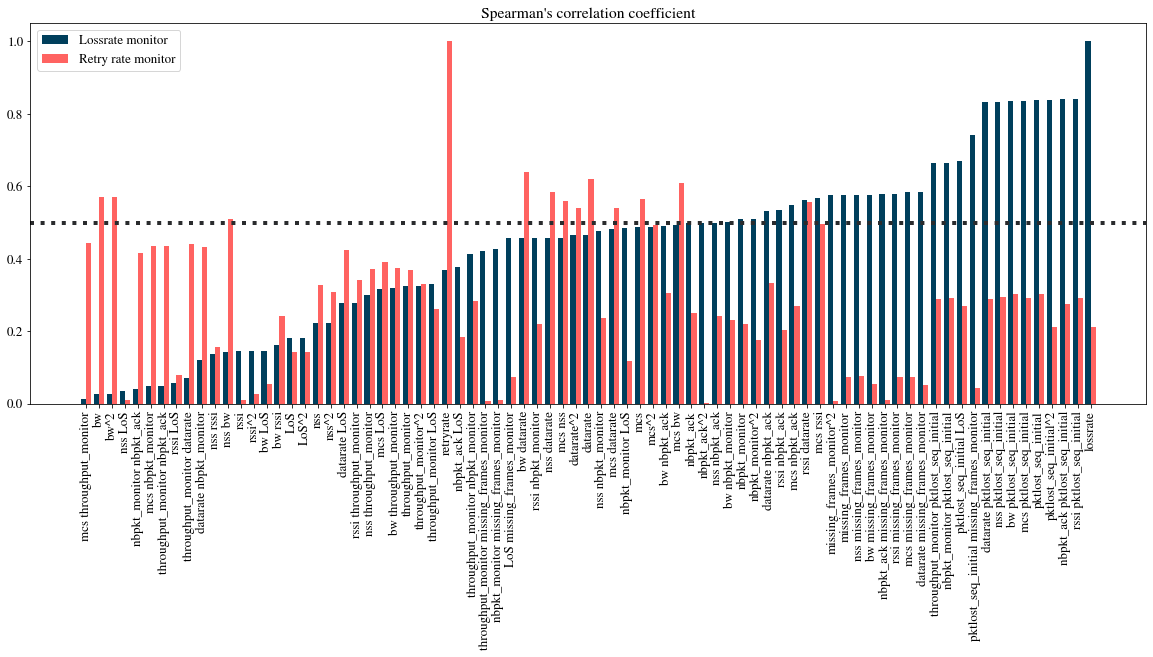

In [35]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='spearman')
plt.title('Spearman\'s correlation coefficient')
plt.savefig('figures/spearman_corr.png', dpi=300, bbox_inches='tight')

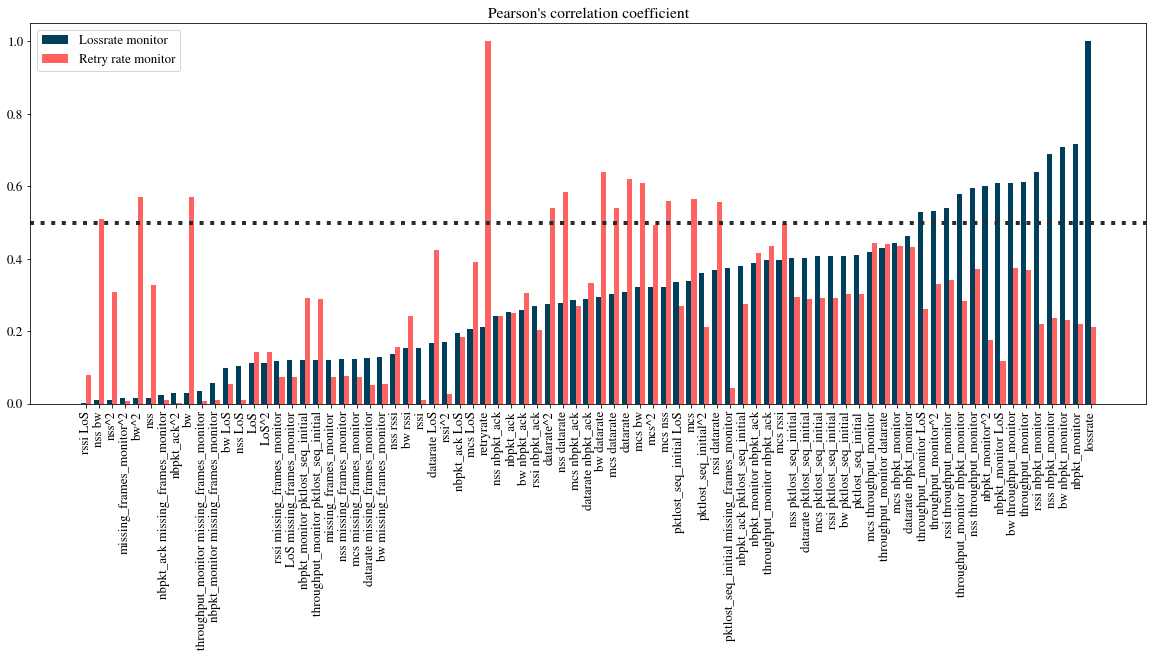

In [36]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='pearson')
plt.title('Pearson\'s correlation coefficient')
plt.savefig('figures/pearson_corr.png', dpi=300, bbox_inches='tight')

<h4> TO DO: conclusions here.</h4>

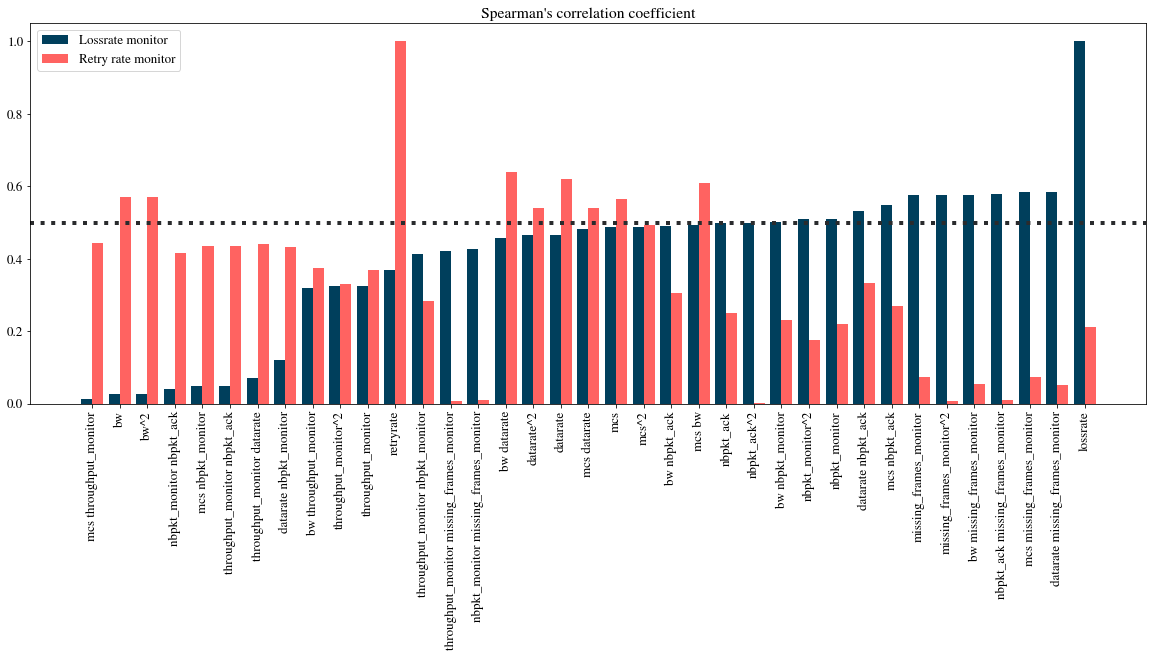

In [37]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'rssi', 'LoS', 'nss', 'pktlost_seq_initial'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='spearman')
plt.title('Spearman\'s correlation coefficient')
plt.savefig('figures/spearman_corr_reduced.png', dpi=300, bbox_inches='tight')

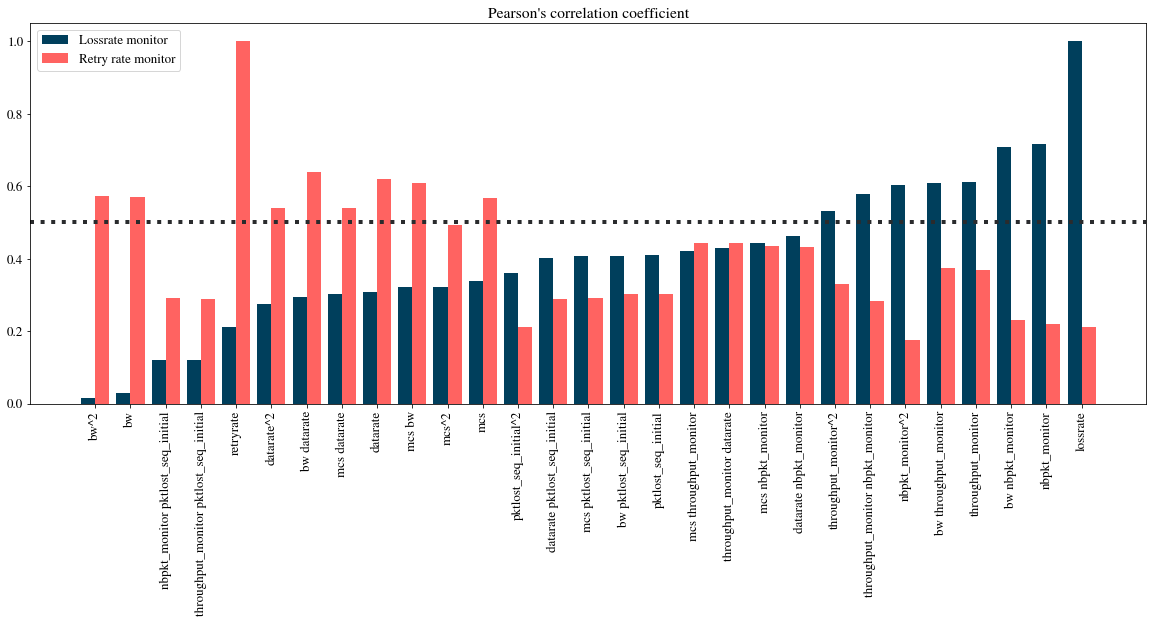

In [38]:
X = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'nss', 'LoS', 'missing_frames_monitor', 'rssi', 'nbpkt_ack'], axis=1, errors='ignore')
y_loss = data_all['lossrate_monitor'].copy()
y_retry = data_all['retry_monitor']
features_correlation_simple(X, y_loss, y_retry, scenario=data_all['Scenario'], degree=2, method='pearson')
plt.title('Pearson\'s correlation coefficient')
plt.savefig('figures/pearson_corr_reduced.png', dpi=300, bbox_inches='tight')

In [39]:
def correlations_per_scenario(data, data_all, degree=2, metric = 'retry_monitor', type='pearson'):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(data)
    poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(input_features=data.columns))
    poly_features[metric] = data_all[metric]
    poly_features['Scenario'] = data_all['Scenario']
    correlation_complete = pd.DataFrame()
    for i in data_all['Scenario'].unique():
        a = pd.DataFrame(data=poly_features.loc[data_all['Scenario'] == i].corr(method=type)[metric])
        # a['Scenario'] = i
        # print(poly_features.loc[data_all['Scenario'] == i].corr()['retry_monitor'])
        correlation_complete = pd.concat([correlation_complete, a], axis=1)
    correlation_complete = correlation_complete.sort_index(axis=1)
    correlation_complete.columns = data_all['Scenario'].unique()
    return correlation_complete

<h4>Correlation heatmaps</h4>
The heatmaps only show selected features (chosen with trial and error) so as to have legible figures. 

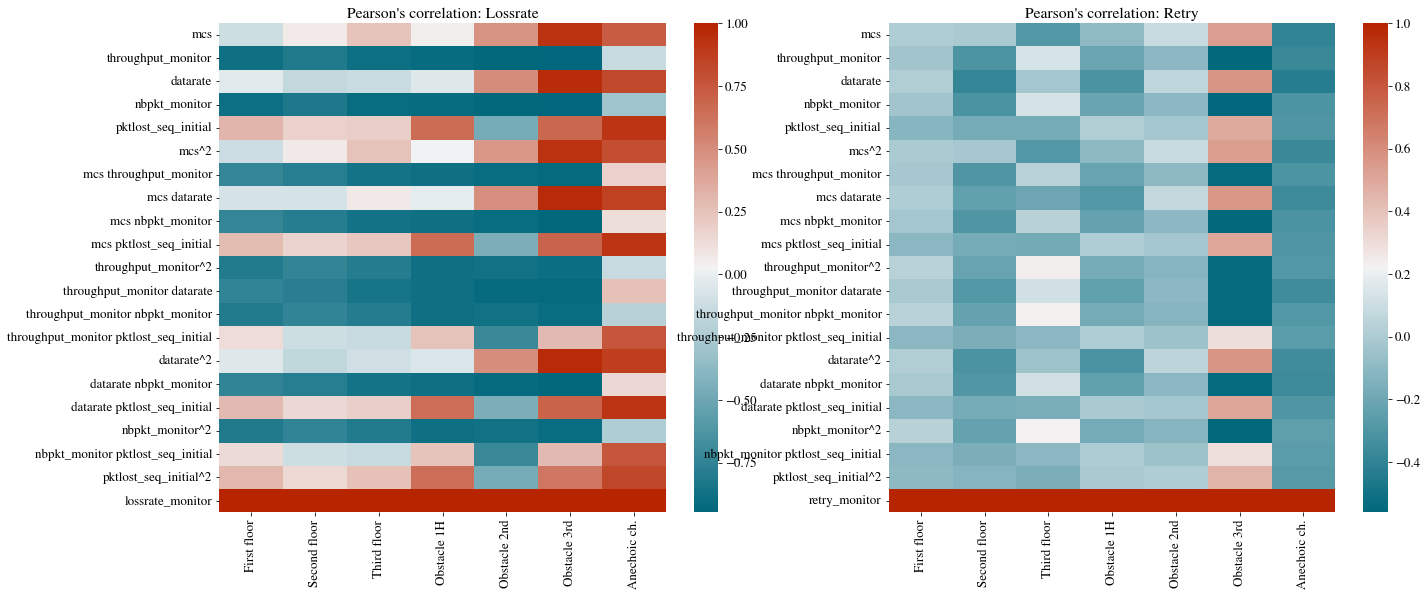

In [40]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'nss', 'LoS', 'missing_frames_monitor', 'rssi', 'bw', 'nbpkt_ack'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Pearson\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Pearson\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

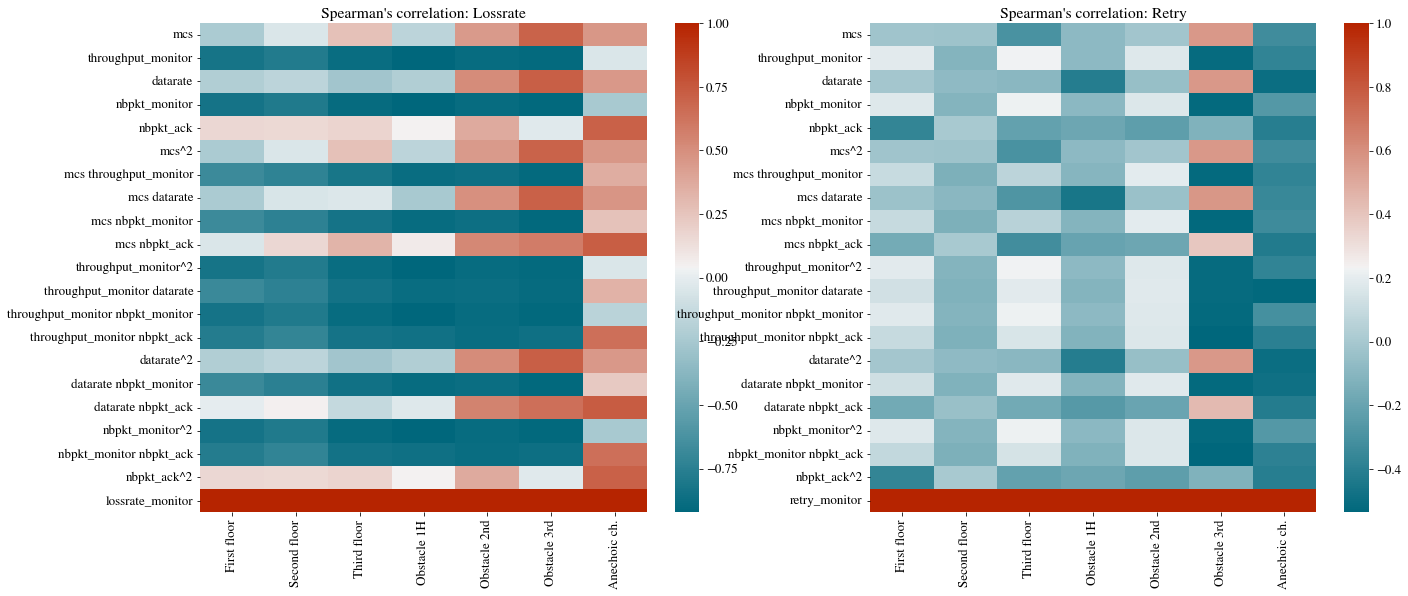

In [41]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'bw', 'LoS', 'nss', 'pktlost_seq_initial', 'rssi', 'missing_frames_monitor'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor', type='spearman')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Spearman\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Spearman\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor', type='spearman')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

/home/marija/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/home/marija/.local/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4868: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


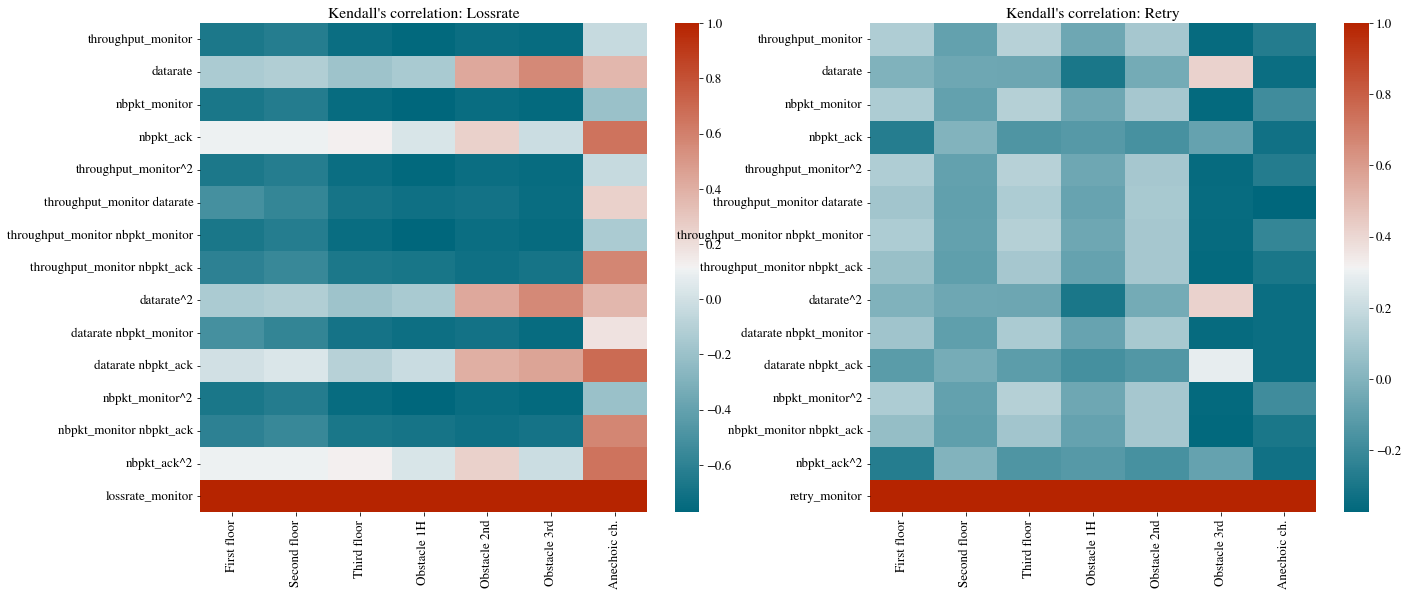

In [42]:
data_new = data_all.drop(['time', 'retry', 'retry_monitor', 'Scenario', 'antenna', 'lossrate_ack', 'lossrate_monitor', 'retry_ack', 'missing_frames_ack', 'distance', 'pktlost_seq_new', 'pktlost_ack', 'pktlost_seq_initial', 'missing_frames_monitor', 'mcs', 'rssi', 'bw', 'LoS', 'nss'], axis=1, errors='ignore')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='lossrate_monitor', type='kendall')
plt.figure(figsize=(22,9))
plt.subplot(1,2,1)
plt.title('Kendall\'s correlation: Lossrate')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.subplot(1,2,2)
plt.title('Kendall\'s correlation: Retry')
correlations_complete = correlations_per_scenario(data=data_new, data_all=data_all, degree=2, metric='retry_monitor', type='kendall')
sns.heatmap(data=correlations_complete, cmap=sns.diverging_palette(h_neg=220, h_pos=15, s=100, l=40, as_cmap=True))
plt.show()

<h4>Correlation conclusions</h4>

**Retry rate** (retries/nb frames captured by monitor)
<li>It will likely be difficult to build a precise prediction model. Both Spearman's (any monotonous function between the two variables) and Pearson's (a linear function between the variables) correlation coefficients show very weak links between the retry rate (number of retries / number of frames counted by monitor) and any other feature. It is less true for specific scenarios, i.e., the anechoic chamber and the 3rd floor with obstacle.  </li>


**Lossrate** (sequence number errors/nb frames captured by monitor)
<li>The correlationas are much stronger, however they are very different for the anechoic chamber and the corridor (as we expected). However, we can now explicitly see that the lossrate computed for the anechoic chamber is strongly correlated to the number of frames counted as well received in the acknowledgements. This is a bit weird, as the anechoic data is lacking most acknowledments, so I am not sure what the proper interpretation is. It is possible that the few well-received ACKs still allow to accurately estimate the number of well received frames. However, this would not explain why the correlation is sometimes opposite (plus vs minus) for the corridor and the anechoic data. Another option (I am more convinced by this), is that the specificity of the anechoic traces results in a computational behavior that is not necessarily representative of the actual link between the lossrate and what is acknowledged in the ACKs, but it does create an artificial correlation between the two. </li>
<li>I try to look at Kendall's correlation as well, because some mention it as an improvement of Spearman's, but I am still not sure about the interpretation. "Intuitively, the Kendall correlation between two variables will be high when observations have a similar (or identical for a correlation of 1) rank (i.e. relative position label of the observations within the variable: 1st, 2nd, 3rd, etc.) between the two variables, and low when observations have a dissimilar (or fully different for a correlation of −1) rank between the two variables." This makes sense for us, as it means that if the sorted observations have a similar order for two different features, then those two features are correlated.</li>
<li>As before, I'll try to make a general model that covers all the data, and a specific model for the corridor and the anechoic data</li>

<h2>Building the model</h2>

In [43]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

linear_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)
poly_pipe = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler()), 
            ("regressor", LinearRegression()),]
)

def plot_model(X_train, y_train, X_test, y_test, model_class, alphas, antenna_names=[], **model_kargs):
    for alpha in alphas:
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        # linear model
        linear_pipe = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()), 
                    ("regressor", model),]
        )
        linear_model = linear_pipe.fit(X_train, y_train)
        y_predict_linear = linear_model.predict(X_test)
        linear_score = linear_model.score(X_test, y_test)
        # calculate sorted coefficients
        feature_names = linear_model.named_steps['scaler'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
        feature_coefs = linear_model.named_steps['regressor'].coef_
        sorted_indexes = abs(feature_coefs).argsort()
        sorted_coef_linear = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
        
        # polynomial model
        poly_pipe = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median")),
                   ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", StandardScaler()), 
                    ("regressor", model),]
        )
        poly_model = poly_pipe.fit(X_train, y_train)
        y_predict_poly = poly_model.predict(X_test)
        poly_score = poly_model.score(X_test,y_test)
        # calculate sorted coefficients
        feature_names = poly_model.named_steps['poly'].get_feature_names_out(input_features=X_train.columns.append(antenna_names))
        feature_coefs = poly_model.named_steps['regressor'].coef_
        sorted_indexes = abs(feature_coefs).argsort()
        sorted_coef_poly = np.c_[feature_names[sorted_indexes], feature_coefs[sorted_indexes]]
        
        plt.rcParams["figure.figsize"] = (5,7)
        plt.figure(1)
        plt.grid()
        sns.scatterplot(x=y_test, y=y_predict_linear, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette=colorlist_summer_divergent[0:len(hue_markers.unique())])
        plt.plot(y_test, y_test, label='Ideal', c='k')
        plt.xlabel('Groud truth', fontsize=20)
        plt.ylabel('Prediction', fontsize=20)        
        plt.legend(loc='lower right', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.ylim([-0.2, 1.2])

        plt.figure(2)
        plt.grid()
        sns.scatterplot(x=y_test, y=y_predict_poly, alpha=0.3, s=40, linewidth=0.1, hue=hue_markers, palette = colorlist_summer_divergent[0:len(hue_markers.unique())])
        plt.plot(y_test, y_test, label='Ideal', c='k')
        plt.xlabel('Groud truth', fontsize=20)
        plt.ylabel('Prediction', fontsize=20)
        plt.legend(loc='lower right', fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)        
        plt.ylim([-0.2, 1.2])
        
        print("Linear and poly R2 scores: ", linear_score, poly_score)
        print("Linear and poly mean absolute error: ", mean_absolute_error(y_test, y_predict_linear), mean_absolute_error(y_test, y_predict_poly))
        print("Linear and poly RMSE: ", mean_squared_error(y_test, y_predict_linear, squared=False), mean_squared_error(y_test, y_predict_poly, squared=False))
        return linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test, y_predict_poly

Linear and poly R2 scores:  0.6086919487857141 0.7653808352126136
Linear and poly mean absolute error:  0.07506913847523362 0.041011313586751426
Linear and poly RMSE:  0.12020624751642967 0.09307850311404459


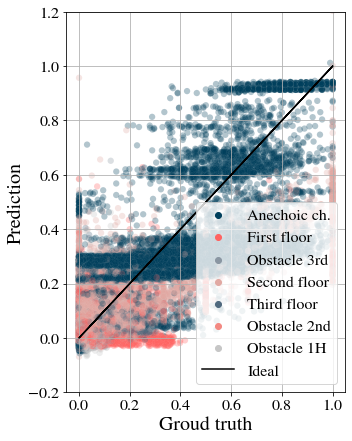

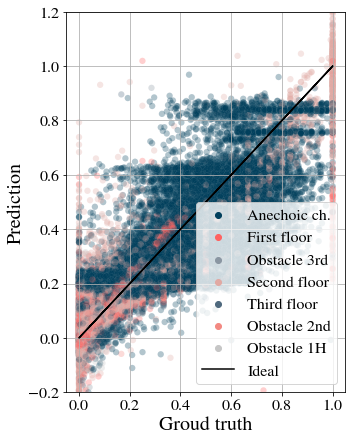

In [44]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data_all.drop(['antenna', 'Scenario', 'retry', 'retry_monitor'], axis=1)#[['mcs', 'bw', 'datarate', 'rx', 'nss', 'throughput']]
y = data_all['retry_monitor'].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data_all) , 20)
y_binned = np.digitize(y, bins)
for train_index, test_index in split.split(data_all, y_binned):
    hue_markers = data_all['Scenario'].loc[test_index]
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])


Linear and poly R2 scores:  0.6086919487857141 0.7653808352126136
Linear and poly mean absolute error:  0.07506913847523362 0.041011313586751426
Linear and poly RMSE:  0.12020624751642967 0.09307850311404459


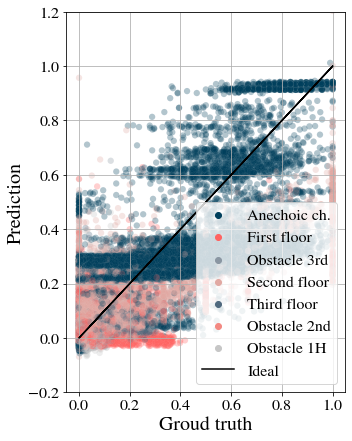

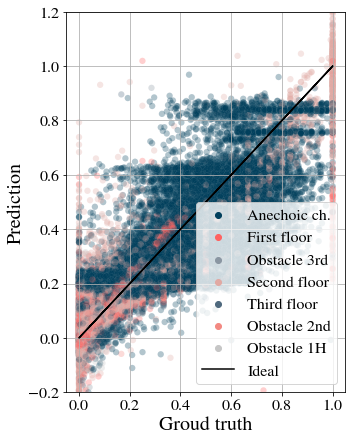

In [45]:
from sklearn.model_selection import StratifiedShuffleSplit
data = data_all.copy()
X = data.drop(['antenna', 'Scenario', 'retry', 'retry_monitor'], axis=1)#[['mcs', 'bw', 'datarate', 'rx', 'nss', 'throughput']]
y = data['retry_monitor'].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data) , 20)
y_binned = np.digitize(y, bins)
for train_index, test_index in split.split(data, y_binned):
    hue_markers = data['Scenario'].loc[test_index]
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])
plt.show()

It's really not a surprise that we cannot predict it that well, as all the correlation coefficients were very low. We could make indivudual models per scenario, but I am afraid we will just be overfitting to the data very fast.

<h4>Lossrate</h4>

The lossrate here is the ratio between the number of frames counted as missing (using the initial computation based on the missing sequence numbers where we only record the event that a loss occured, but we do not know if it is a single frame or several) and the number of frames captured by the monitor.

Linear and poly R2 scores:  0.7211380461199548 0.8565113917844666
Linear and poly mean absolute error:  0.11174805575531596 0.061005691901491084
Linear and poly RMSE:  0.14860197564567962 0.1065954486727706


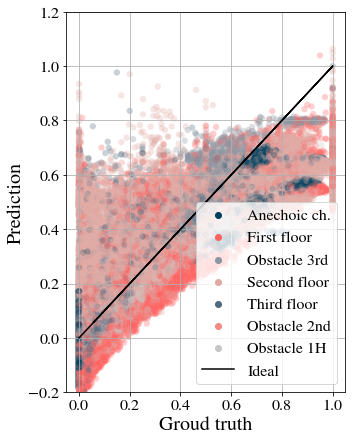

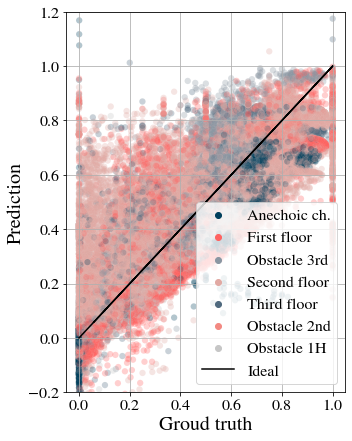

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit
data = data_all.copy()
# X = data.drop(['antenna', 'Scenario', 'retry', 'lossrate_monitor', 'pktlost_seq_initial', 'pktlost_seq_new'], axis=1)#[['mcs', 'bw', 'datarate', 'rx', 'nss', 'throughput']]
X = data[['throughput_monitor', 'nbpkt_monitor', 'datarate', 'mcs', 'nbpkt_ack']]
y = data['lossrate_monitor'].copy()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
bins = np.linspace(0, len(data) , 20)
y_binned = np.digitize(y, bins)
for train_index, test_index in split.split(data, y_binned):
    hue_markers = data['Scenario'].loc[test_index]
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y.loc[train_index]
    y_test = y.loc[test_index]
linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])

In [47]:
from scipy import stats
stats.ks_2samp(data_all['pktlost_seq_new'], data_all['retry'])

KstestResult(statistic=0.5296947802012291, pvalue=0.0)

<h4>Lossrate model per scenario</h4>

Linear and poly R2 scores:  0.8187633072265408 0.8658488656887665
Linear and poly mean absolute error:  0.061487692301535744 0.044919943192883754
Linear and poly RMSE:  0.10535945663877032 0.0906457887974653


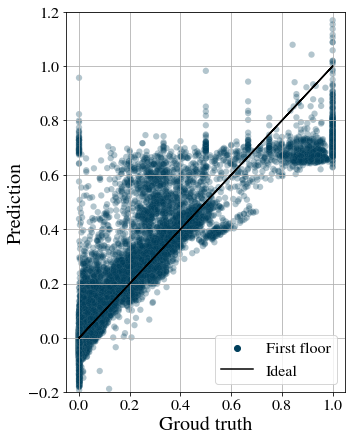

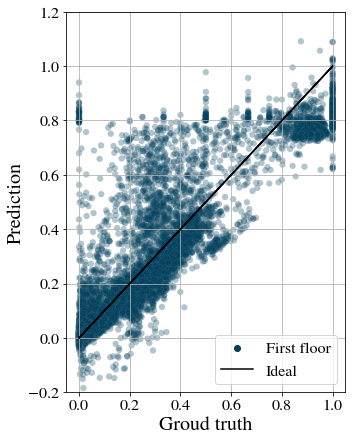

Linear and poly R2 scores:  0.7340508368278857 0.8152238352494365
Linear and poly mean absolute error:  0.11074291205483702 0.08408796688104335
Linear and poly RMSE:  0.1573223277484371 0.13113361202534618


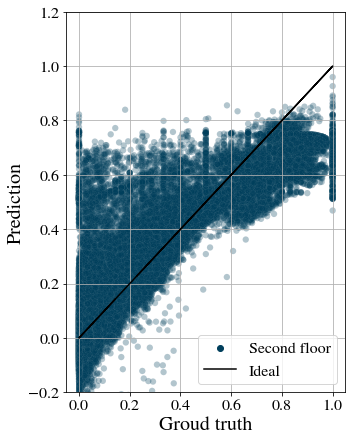

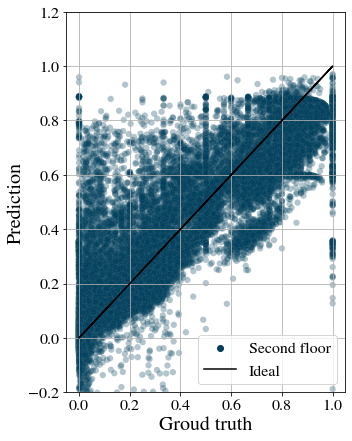

Linear and poly R2 scores:  0.818626159226675 0.8920074682082916
Linear and poly mean absolute error:  0.06564798347197401 0.04198595657764072
Linear and poly RMSE:  0.10199316168452886 0.07870106172556586


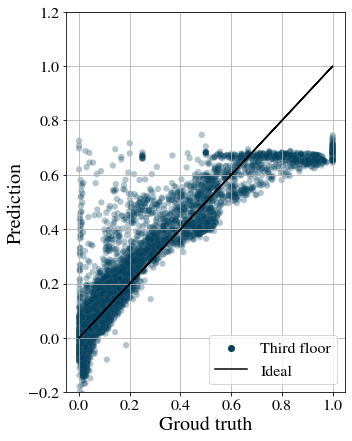

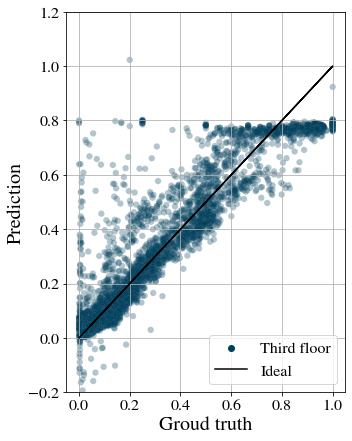

Linear and poly R2 scores:  0.8864565706499874 0.9315722880129964
Linear and poly mean absolute error:  0.05448544499772942 0.03348281271771294
Linear and poly RMSE:  0.07763060404349496 0.0602653899826286


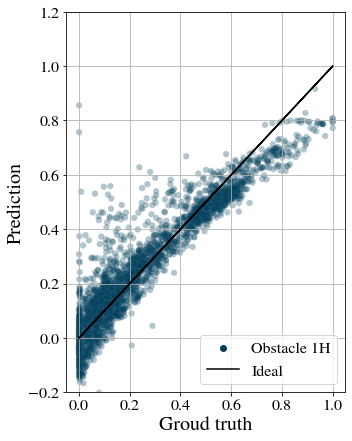

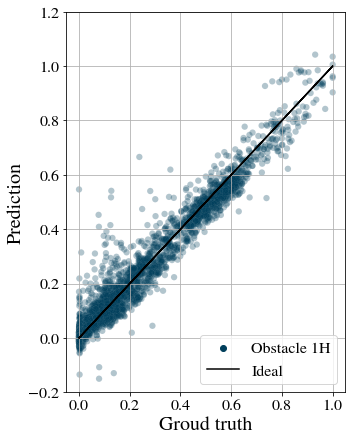

Linear and poly R2 scores:  0.9037722851610454 0.9420150092394625
Linear and poly mean absolute error:  0.07199272435763288 0.04837981827271724
Linear and poly RMSE:  0.10357473834699006 0.08040101931615212


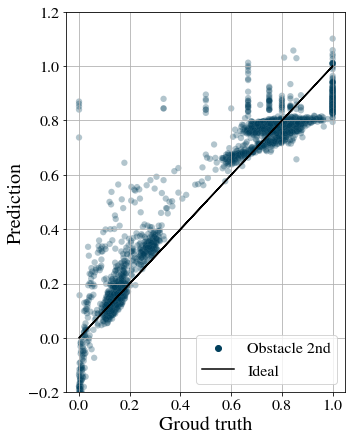

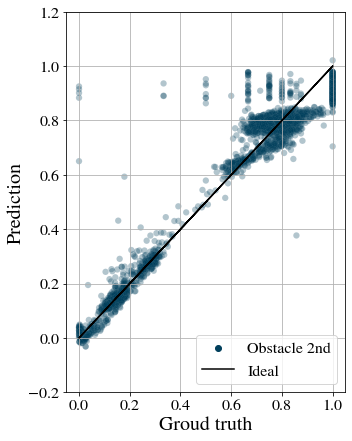

Linear and poly R2 scores:  0.9626866709957247 0.9731215312301278
Linear and poly mean absolute error:  0.030021925488060316 0.025423822107613722
Linear and poly RMSE:  0.04779874036425352 0.040568291213163


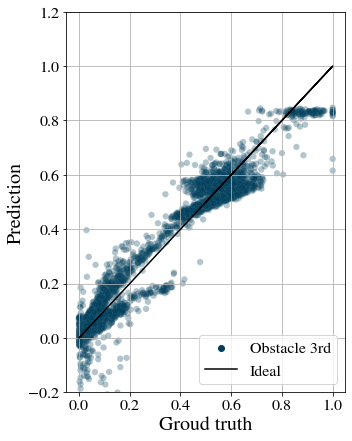

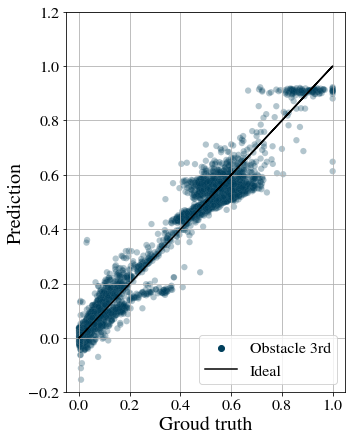

Linear and poly R2 scores:  0.9319569227996085 0.9793516815817204
Linear and poly mean absolute error:  0.02593046335035569 0.008277500941901713
Linear and poly RMSE:  0.050392589832232555 0.027759845844929538


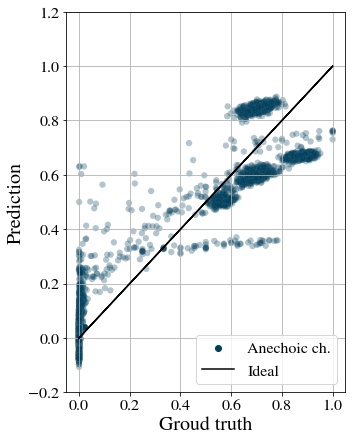

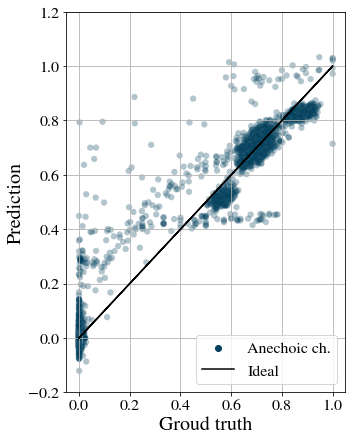

In [48]:
for i in frames:
    data = i.copy()
    X = data[['throughput_monitor', 'nbpkt_monitor', 'datarate', 'mcs', 'nbpkt_ack']]
    y = data['lossrate_monitor'].copy()

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    bins = np.linspace(0, len(data) , 20)
    y_binned = np.digitize(y, bins)
    for train_index, test_index in split.split(data, y_binned):
        hue_markers = data['Scenario'].loc[test_index]
        X_train = X.loc[train_index]
        X_test = X.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    linear_model, poly_model, sorted_coef_linear, sorted_coef_poly, y_test_all, y_predict_poly_all =  plot_model(X_train, y_train, X_test, y_test, Ridge, [1])
    plt.show()

<h4>To do:</h4>

Look into the coefficients of the models for the different scenarios. 

Do a mix and match with training data and testing data. 